# Text Classification Lab
In this lab session we will focus on the use of Neural Word Embeddings 


## Table of Contents
1. Data preparation
2. Feature engineering
3. Model
4. Results evaluation
5. Other things you could try
6. Deep Learning
7. Word to Vector
8. Clustering
9. High-dimension Visualization



### Necessary Library Requirements:


- [Jupyter](http://jupyter.org/) (Strongly recommended but not required)
    - Install via `pip3 install jupyter` and use `jupyter notebook` in terminal to run
- [Scikit Learn](http://scikit-learn.org/stable/index.html)
    - Install via `pip3 sklearn` from a terminal
- [Pandas](http://pandas.pydata.org/)
    - Install via `pip3 install pandas` from a terminal
- [Numpy](http://www.numpy.org/)
    - Install via `pip3 install numpy` from a terminal
- [Matplotlib](https://matplotlib.org/)
    - Install via `pip3 maplotlib` from a terminal
- [Plotly](https://plot.ly/)
    - Install via `pip3 install plotly` from a terminal
- [Seaborn](https://seaborn.pydata.org/)
    - Install and signup for `seaborn`
- [NLTK](http://www.nltk.org/)
    - Install via `pip3 install nltk` from a terminal

- [Gensim](https://pypi.org/project/gensim/)
    - Install via `pip3 install gensim`

- [tensorflow](https://www.tensorflow.org/)
    - Install via `pip3 install tensorflow`
    - Also install `pip3 install tensorflow-hub`

- [Keras](https://keras.io/)
    - Install via `pip3 install keras`

## Mount Folder from Google Drive

In [ ]:
!nvidia-smi

Fri Dec 23 00:56:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!npx degit https://github.com/mequanent/Social-Networks -f

npx: installed 1 in 2.18s
> destination directory is not empty. Using --force, continuing
> cloned mequanent/Social-Networks#HEAD


In [7]:
#@title Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import os 
import itertools

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import tensorflow as tf

## ignore warnings
import warnings
warnings.filterwarnings('ignore') 

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# show the folder 
data_folder = "/content/text_lab" # this is where you upload your zip file at 
os.listdir(data_folder) 

['data',
 'test_df.pkl',
 'HW.ipynb',
 'Text_Classification_Lab.ipynb',
 'train_df.pkl',
 'logs',
 'pics']

---
## Introduction

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embedding and other deep information retrieval approaches.

![pic0](https://drive.google.com/uc?id=1W8Y2zAO0IUP86GgGASHW96YK74UGOavA)

---
## 1. Data Preparation

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [ ]:
os.path.join(data_folder, "data/semeval/train/anger-ratings-0to1.train.txt")

'/content/text_lab/data/semeval/train/anger-ratings-0to1.train.txt'

In [ ]:
f"{data_folder}/data/semeval/train/anger-ratings-0to1.train.txt"

'/content/text_lab/data/semeval/train/anger-ratings-0to1.train.txt'

In [ ]:
### training data
columns = ["id", "text", "emotion", "intensity"]
anger_train = pd.read_csv(f"{data_folder}/data/semeval/train/anger-ratings-0to1.train.txt", 
                          sep="\t", header=None, names=columns)
sadness_train = pd.read_csv(f"{data_folder}/data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=columns)
fear_train = pd.read_csv(f"{data_folder}/data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=columns)
joy_train = pd.read_csv(f"{data_folder}/data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=columns)

In [ ]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [ ]:
train_df['intensity'] > 0.5

0        True
1        True
2        True
3        True
4        True
        ...  
3608    False
3609    False
3610    False
3611    False
3612    False
Name: intensity, Length: 3613, dtype: bool

In [ ]:
train_df[(train_df['emotion']=="anger")&(train_df['intensity'] > 0.5)]

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...
381,10381,don't provoke me after letting me down !,anger,0.521
382,10382,could never be a angry drunk lol yall weirdos ...,anger,0.521
383,10383,"Yet we still have deaths, road rage, &amp; vio...",anger,0.521
396,10396,I have a rage rage ep 2 coming out soon I'll k...,anger,0.520


In [ ]:
train_df['text'].str.replace("How", "howw")

0       howw the fu*k! Who the heck! moved my fridge!....
1       So my Indian Uber driver just called someone t...
2       @DPD_UK I asked for my parcel to be delivered ...
3       so ef whichever butt wipe pulled the fire alar...
4       Don't join @BTCare they put the phone down on ...
                              ...                        
3608    @VivienLloyd Thank you so much! Just home - st...
3609                Just put the winter duvet on ☃️❄️🌬☔️ 
3610    @SilkInSide @TommyJoeRatliff that's so pretty!...
3611    @BluesfestByron second artist announcement loo...
3612    I can literally eat creamy pesto pasta topped ...
Name: text, Length: 3613, dtype: object

In [ ]:
train_df['text_2'] = train_df['text'].str.replace("How", "howw") # assign modified column to original df

In [ ]:
train_df

,id,text,emotion,intensity,text_2
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,howw the fu*k! Who the heck! moved my fridge!....
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,So my Indian Uber driver just called someone t...
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,@DPD_UK I asked for my parcel to be delivered ...
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,so ef whichever butt wipe pulled the fire alar...
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,Don't join @BTCare they put the phone down on ...
...,...,...,...,...,...
3608,40781,@VivienLloyd Thank you so much! Just home - st...,sadness,0.104,@VivienLloyd Thank you so much! Just home - st...
3609,40782,Just put the winter duvet on ☃️❄️🌬☔️,sadness,0.104,Just put the winter duvet on ☃️❄️🌬☔️
3610,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness,0.088,@SilkInSide @TommyJoeRatliff that's so pretty!...
3611,40784,@BluesfestByron second artist announcement loo...,sadness,0.083,@BluesfestByron second artist announcement loo...


In [ ]:
### testing data
anger_test = pd.read_csv(f"{data_folder}/data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)
sadness_test = pd.read_csv(f"{data_folder}/data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)
fear_test = pd.read_csv(f"{data_folder}/data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)
joy_test = pd.read_csv(f"{data_folder}/data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=columns)

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
test_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [ ]:
train_df.tail(2)

,id,text,emotion,intensity,text_2
3611,40784,@BluesfestByron second artist announcement loo...,sadness,0.083,@BluesfestByron second artist announcement loo...
3612,40785,I can literally eat creamy pesto pasta topped ...,sadness,0.083,I can literally eat creamy pesto pasta topped ...


In [ ]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [ ]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape) 

Shape of Training df:  (3613, 5)
Shape of Testing df:  (347, 4)


In [ ]:
train_df.tail(2)

,id,text,emotion,intensity,text_2
120,10120,@FoxNews @SheriffClarke @FoxNewsInsider This m...,anger,0.688,@FoxNews @SheriffClarke @FoxNewsInsider This m...
428,10428,"@voguemagazine, did you not learn from @FreePe...",anger,0.479,"@voguemagazine, did you not learn from @FreePe..."


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. 
(Try to implement this by yourself!)

In [ ]:
train_df['text'].values[0].split(' ')

['I',
 'like',
 'the',
 'commercial',
 'where',
 '@kohara19,',
 'on',
 'a',
 'chocolate',
 'milk',
 'bender,',
 'steals',
 'a',
 'soccer',
 'ball',
 'from',
 'some',
 'guys',
 'and',
 'refuses',
 'to',
 'give',
 'it',
 'back.',
 '']

In [3]:
# Answer here
def get_frequencies(df, col):
  #pd.Series(' '.join(df.[col]).split()).value_counts()#[:30]
  words = ' '.join(df[col]) # merge all text contents
  words = words.split() # tokenize words
  words = pd.Series(words) # list to pandas series for easier counting 
  return words.value_counts() # return the frequency of word in descending order

In [ ]:
# 

train_freq = get_frequencies(train_df, 'text')[:30] # frequency of words in train_df.text
test_freq = get_frequencies(test_df, 'text')[:30] # frequency of words in test_df.text

fig1 = px.bar(train_freq, x=train_freq.index, y=train_freq.values, 
              title="Top 30 frequent words from the TRAINING dataset",
             labels=dict(x="Words", y="Frequencies"))
fig2 = px.bar(test_freq, x=test_freq.index, y=test_freq.values, 
              title="Top 30 frequent words from the TESTING dataset",
              labels=dict(x="Words", y="Frequencies"))
fig1.show(), fig2.show()

both = pd.concat([train_df, test_df], ignore_index=True)
word_freq = get_frequencies(both, 'text')[:30] # frequency of words in both train_df.text
fig = px.bar(word_freq, x=word_freq.index, y=word_freq.values, 
              title="Top 30 frequent words from BOTH TRAINING AND TESTING dataset",
              labels=dict(x="Words", y="Frequencies")) 
fig.show() 

---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [ ]:
## save to pickle file
train_df.to_pickle(os.path.join(data_folder, "train_df.pkl")) 
test_df.to_pickle(os.path.join(data_folder, "test_df.pkl"))

In [4]:
## load a pickle file
train_df = pd.read_pickle(os.path.join(data_folder, "train_df.pkl"))
test_df = pd.read_pickle(os.path.join(data_folder, "test_df.pkl"))

For more information: https://reurl.cc/0Dzqx

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [ ]:
# group to find distribution 
train_df.groupby(['emotion']).count()['intensity'] 

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: intensity, dtype: int64

In [ ]:
train_df['emotion'].value_counts() 

fear       1147
anger       857
joy         823
sadness     786
Name: emotion, dtype: int64

In [ ]:
df1 = train_df.groupby(['emotion']).count()['text'] 
df1

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

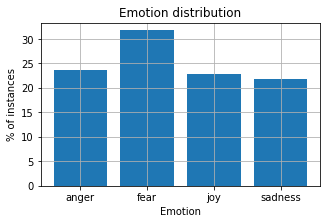

In [5]:
# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text'] 
df1 = df1.apply(lambda x: round(x*100/post_total,3)) # y value

# plot 
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values) # ( x value, y value)

# arrange 
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show() 

10 mins break to 10:28

---

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

In [ ]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [ ]:
# check the result
train_data_BOW_features 

<3613x10115 sparse matrix of type '<class 'numpy.int64'>'
	with 51467 stored elements in Compressed Sparse Row format>

In [ ]:
type(train_data_BOW_features) 

scipy.sparse.csr.csr_matrix

In [ ]:
# add .toarray() to show
train_data_BOW_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# check the dimension
train_data_BOW_features.shape

(3613, 10115)

In [ ]:
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out() 
feature_names[100:110] 

array(['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s',
       '31'], dtype=object)

In [ ]:
sum(train_data_BOW_features.toarray()[0])

3

The embedding is done. We can technically feed this into our model. However, depending on the embedding technique you use and your model, your accuracy might not be as high, because:

* curse of dimensionality  (we have 10,115 dimension now)
* some important features are ignored (for example, some models using emoticons yeld better performance than counterparts)

In [ ]:
"😂" in feature_names

False

Let's try using another tokenizer below.

In [ ]:

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3613, 500)

In [ ]:
train_data_BOW_features_500.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['change', 'cheer', 'cheerful', 'cheerfully', 'cheering', 'cheery',
       'come', 'comes', 'could', 'country'], dtype=object)

In [ ]:
"😂" in feature_names_500

True

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [ ]:
# Answer here 


In [ ]:
# build analyzers (tf-idf)
tfidf_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
tfidf_1000.fit(train_df['text'])

train_data_tfidf_features_1000 = tfidf_1000.transform(train_df['text'])

# observe some feature names
feature_names_1000 = tfidf_1000.get_feature_names_out()
feature_names_1000[100:110] 

array(['awful', 'b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc',
       'bday'], dtype=object)

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [ ]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [ ]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)
# finish training!

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['fear', 'anger', 'anger', 'fear', 'joy', 'fear', 'sadness', 'fear',
       'sadness', 'fear'], dtype=object)

In [ ]:
y_train_pred[:5]

array(['fear', 'joy', 'anger', 'joy', 'fear'], dtype=object)

---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [ ]:
## accuracy
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.99
testing accuracy: 0.68


In [ ]:
1/(4.0) # random guess

0.25

In [ ]:
## precision, recall, f1-score,
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347



In [ ]:
## check by confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[57 18  6  3]
 [16 76  9  9]
 [ 6  9 56  8]
 [ 7 13  7 47]]


In [ ]:
# Funciton for visualizing confusion_matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

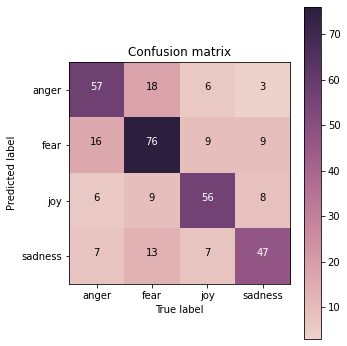

In [ ]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

In [ ]:
# Answer here


---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [ ]:
# Answer here


              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347



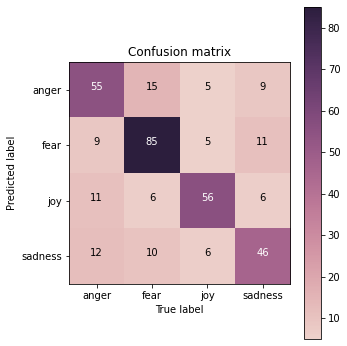

In [ ]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## build Naive Bayes model
NB_model = MultinomialNB()

## training!
NB_model = NB_model.fit(X_train, y_train)

## predict!
y_train_pred_nb = NB_model.predict(X_train)
y_test_pred_nb = NB_model.predict(X_test)

acc_train_nb = accuracy_score(y_true=y_train, y_pred=y_train_pred_nb)
acc_test_nb = accuracy_score(y_true=y_test, y_pred=y_test_pred_nb)

## precision, recall, f1-score
print(classification_report(y_true=y_test, y_pred=y_test_pred_nb))

## check by confusion matrix
cm_nb = confusion_matrix(y_true=y_test, y_pred=y_test_pred_nb) 

plot_confusion_matrix(cm_nb, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

In [ ]:
# Answer here


---

## 5. Other things you can try

Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by: 
- Trying different features (Feature engineering)e.g Word2Vec, PCA, LDA, FastText, Clustering
- Trying different models
- Analyzing your results and interpret them to improve your feature engineering/model building process
- Iterate through the steps above until finding a satisfying result

Remember that you should also consider the task at hand and the model you'll feed the data to. 

we have finished the traditional classifier and features


10 mins break and back on 11:18.

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models. 

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

![Fully Connected Network](https://drive.google.com/uc?id=1W7WqyYIfMq4CU5iWPAw5JOdEs_FfYyx7)

(source: https://github.com/drewnoff/spark-notebook-ml-labs/tree/master/labs/DLFramework)


### 6.1 Prepare data (X, y)

In [ ]:
# import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves. 

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [ ]:
## deal with label (string -> one-hot)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1939     fear
2239      joy
758     anger
2406      joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


In [ ]:
tf.__version__

'2.9.2'

In [ ]:

def label_encode(le, labels):
    enc = le.transform(labels)
    return tf.keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)




## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [ ]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![Imgur](https://drive.google.com/uc?id=1W4mPnKGWF8VXZ2pmiefNAYfIK0dncO00)

In [ ]:
# from tf.keras import Model
# from tf.keras.layers import Input, Dense
# from tf.keras.layers import ReLU, Softmax

# input layer
model_input = tf.keras.Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
H1 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(X)  # 64

# 2nd hidden layer
H2 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(H1)  # 64

# output layer
H3 = tf.keras.layers.Dense(units=output_shape, activation=tf.nn.softmax)(H2)  # 4

model_output = H3

# create model
model = tf.keras.Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 36,484
Trainable params: 36,484
Non-trainable params: 0
_________________________________________________________________


### 6.4 Train

In [ ]:
# from keras.callbacks import CSVLogger

csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(data_folder,'logs/training_log.csv'))

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))

print('training finish')

Epoch 1/25
113/113 [==============================] - 2s 6ms/step - loss: 1.3245 - accuracy: 0.3642 - val_loss: 1.2744 - val_accuracy: 0.4409
Epoch 2/25
113/113 [==============================] - 1s 5ms/step - loss: 0.9703 - accuracy: 0.6607 - val_loss: 0.8988 - val_accuracy: 0.6628
Epoch 3/25
113/113 [==============================] - 1s 5ms/step - loss: 0.5747 - accuracy: 0.7963 - val_loss: 0.7837 - val_accuracy: 0.6916
Epoch 4/25
113/113 [==============================] - 1s 5ms/step - loss: 0.4138 - accuracy: 0.8497 - val_loss: 0.7603 - val_accuracy: 0.7003
Epoch 5/25
113/113 [==============================] - 1s 5ms/step - loss: 0.3281 - accuracy: 0.8849 - val_loss: 0.8419 - val_accuracy: 0.6916
Epoch 6/25
113/113 [==============================] - 1s 4ms/step - loss: 0.2691 - accuracy: 0.9106 - val_loss: 0.8988 - val_accuracy: 0.6744
Epoch 7/25
113/113 [==============================] - 1s 5ms/step - loss: 0.2212 - accuracy: 0.9275 - val_loss: 0.9584 - val_accuracy: 0.7003
Epoch 

### 6.5 Predict on testing data

In [ ]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3/3 [==============================] - 0s 4ms/step


array([[5.7447880e-07, 5.0788361e-07, 9.9999893e-01, 1.8743684e-08],
       [4.5493336e-05, 3.1042303e-04, 1.7591972e-04, 9.9946815e-01],
       [5.7282978e-06, 9.8181497e-03, 8.3005432e-07, 9.9017531e-01],
       [4.9844262e-01, 2.8788382e-01, 6.8797992e-05, 2.1360473e-01],
       [3.8276491e-07, 5.6500515e-09, 9.9999881e-01, 7.9206421e-07]],
      dtype=float32)

In [ ]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['joy', 'sadness', 'sadness', 'anger', 'joy'], dtype=object)

In [ ]:
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.66


In [ ]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv(os.path.join(data_folder,"logs/training_log.csv"))
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.364240,1.324480,0.440922,1.274364
1,1,0.660670,0.970311,0.662824,0.898775
2,2,0.796291,0.574712,0.691643,0.783747
3,3,0.849709,0.413788,0.700288,0.760350
4,4,0.884860,0.328108,0.691643,0.841892
5,5,0.910601,0.269097,0.674352,0.898824
6,6,0.927484,0.221225,0.700288,0.958437
7,7,0.938278,0.192032,0.677233,1.022067
8,8,0.952117,0.159175,0.688761,1.084578
9,9,0.957099,0.142877,0.659942,1.169402


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="https://drive.google.com/uc?id=1W0KWZWP6vNW5ogZpzdb0EWo_4pOsENjA" style="width: 300px;"/> </td>
    <td><img src="https://drive.google.com/uc?id=1VxoCrhIXOOlJhk6QmHLMQ5bUVEZ9NC1i" style="width: 300px;"/> </td>
</tr></table>

In [ ]:
# Answer here


---

### Note

We recommend you to use the GPU in colab to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 12 hours. After 12 hours of training/connection, your kernel will shut down (meaning if your model takes more than 12 hours to train, you can't train it at once).


### More Information for your reference

* TF keras document: https://www.tensorflow.org/api_docs/python/tf/keras
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [ ]:
## check library
gensim.__version__ # this is the currect version (4.3.0), otherwise do upgrade
# !pip install -q gensim numpy --upgrade # do this upgrade first, You must restart the runtime in order to use newly installed versions. (restart this notebook)

'4.3.0'

In [ ]:
## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
1939,21082,"I like the commercial where @kohara19, on a ch...","[I, like, the, commercial, where, @, kohara19,..."
2239,30235,@saraandgreg @Airbnb Another happy customer. ...,"[@, saraandgreg, @, Airbnb, Another, happy, cu..."
758,10758,@The_Boxing_Hub #klitschko @Klitschko over fur...,"[@, The_Boxing_Hub, #, klitschko, @, Klitschko..."
2406,30402,@TiburonChamber plus a hearty pour of #yachtro...,"[@, TiburonChamber, plus, a, hearty, pour, of,..."
1169,20312,I feel ghastly and I'm really hoping it's just...,"[I, feel, ghastly, and, I, 'm, really, hoping,..."


In [ ]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['I', 'like', 'the', 'commercial', 'where', '@', 'kohara19', ',', 'on', 'a', 'chocolate', 'milk', 'bender', ',', 'steals', 'a', 'soccer', 'ball', 'from', 'some', 'guys', 'and', 'refuses', 'to', 'give', 'it', 'back', '.']),
       list(['@', 'saraandgreg', '@', 'Airbnb', 'Another', 'happy', 'customer', '.', '#', 'secreteyes']),
       list(['@', 'The_Boxing_Hub', '#', 'klitschko', '@', 'Klitschko', 'over', 'fury', 'any', 'day', '#', 'boxing'])],
      dtype=object)

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20


In [ ]:

## if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)  # in some version size<-> vector_size, iter<->epochs

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 7.3 Generating word vector (embeddings)

In [ ]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.7395814 ,  0.10804593,  0.08314544,  0.20014673, -0.3150654 ,
       -1.3086057 ,  0.5790453 ,  1.450245  , -0.1422182 , -0.6610256 ,
       -0.4476984 , -0.9783194 , -0.6815856 ,  0.31866765, -0.21577597,
       -0.52827764,  0.03014594, -0.75723445,  0.12404435, -0.8113819 ,
        0.35731348,  0.62394726,  0.7784158 ,  0.4539981 ,  0.3298959 ,
        0.16061834, -0.5803066 ,  0.30842644, -0.2866147 ,  0.100098  ,
        0.22118923, -0.23805611,  0.60153204, -0.45925713, -0.55062574,
        0.33792284,  0.38912106, -0.34558222, -0.46214747, -0.47203836,
       -0.02208045, -0.0142757 , -0.4474743 ,  0.62789595,  0.83197904,
       -0.06475295, -1.1713635 ,  0.0077088 ,  0.9466839 ,  0.01184967,
       -0.38204792, -0.10645965,  0.52543956, -0.08445486, -0.49620414,
       -0.5871297 ,  0.22529186, -0.3738886 , -0.4817271 ,  0.35970438,
        0.02276494, -0.2866715 ,  0.6266573 , -0.1660364 , -0.58005685,
        0.70352894,  0.15779251,  0.49636495, -1.442655  ,  0.12

In [ ]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('Be', 0.9180929064750671),
 ("'be", 0.9017777442932129),
 ('birthday', 0.9014620780944824),
 ('successful', 0.9003423452377319),
 ("'you", 0.8949787616729736),
 ('travel', 0.8943163156509399),
 ('🕋', 0.8870147466659546),
 ('help', 0.88575679063797),
 ('cry', 0.8840787410736084),
 ('cats', 0.8805023431777954)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://code.google.com/archive/p/word2vec/)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [ ]:
# Note: this model is very huge, this will take some time ...
model_path = os.path.join(data_folder, "GoogleNews/GoogleNews-vectors-negative300.bin.gz")
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')


#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [ ]:
## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
# import ssl
# import urllib.request
# ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

[==================================================] 100.0% 104.8/104.8MB downloaded
load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158351421356201),
 ('thanks', 0.915008544921875),
 ('merry', 0.9053249359130859),
 ('bless', 0.902732253074646),
 ('wish', 0.9013164043426514)]

In [ ]:
w2v_google_model = api.load('word2vec-google-news-300') # maybe too big for colab

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
w2v_google_model.most_similar('happy', topn=10)

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [ ]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

In [ ]:

glove_twitter_25_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949),
 ('hunter', 0.8131037950515747),
 ('father', 0.8115834593772888),
 ('soldier', 0.81113600730896),
 ('mercy', 0.8082392811775208),
 ('hero', 0.8082264065742493)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


In [ ]:
# Answer here
# try to build classifier with word embedding features

### 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [ ]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [ ]:
# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 1
word: fear 	 cluster: 1
word: angry 	 cluster: 1
word: car 	 cluster: 0
word: teacher 	 cluster: 0
word: computer 	 cluster: 0


![Imgur](https://drive.google.com/uc?id=1Vm0-_k8xh9pDiruqy0uOKkxtpa4pnJq3)

In [ ]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0], dtype=int32)

In [ ]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1], dtype=int32)


## 9. High-dimension Visualization: t-SNE

No matter if you use the Bag-of-words, TF-IDF, or Word2Vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient.

Our aim will be to create a visualization similar to the one below:

![Image](https://drive.google.com/uc?id=1Vl5huV8wa5I6GXcgqz2YLHdeXS4WMR01)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization 

Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

### 9.1 Prepare visualizing target

Let's prepare data lists like:
- happy words
- angry words
- data words
- mining words

In [ ]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in glove_twitter_25_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in glove_twitter_25_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in glove_twitter_25_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in glove_twitter_25_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'birthday', 'thank', 'welcome', 'love', 'miss']
angry_words:  ['angry', 'stupid', 'hate', 'annoying', 'weird', 'like']
data_words:  ['data', 'mobile', 'software', 'search', 'survey', 'web']
mining_words:  ['mining', 'offshore', 'manufacturing', 'pharma', 'agricultural', 'agriculture']

target words: 
['happy', 'birthday', 'thank', 'welcome', 'love', 'miss', 'angry', 'stupid', 'hate', 'annoying', 'weird', 'like', 'data', 'mobile', 'software', 'search', 'survey', 'web', 'mining', 'offshore', 'manufacturing', 'pharma', 'agricultural', 'agriculture']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.2 Plot using t-SNE (2-dimension)

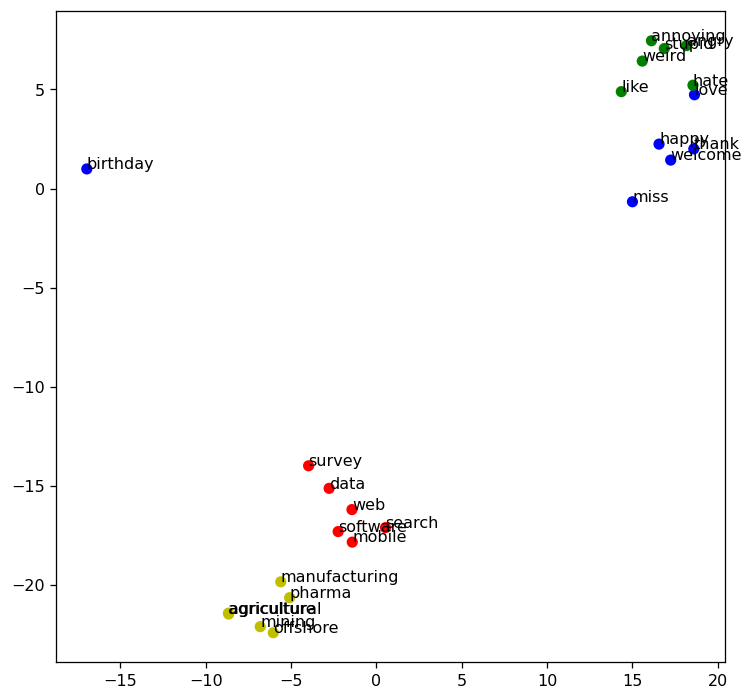

In [ ]:
## w2v model
model = w2v_google_model
# model = glove_twitter_25_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

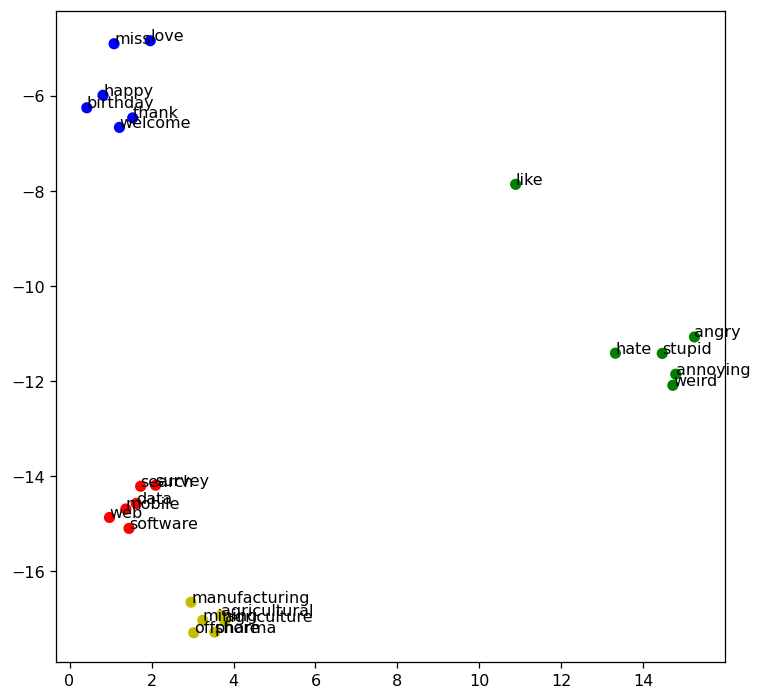

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

## w2v model
# model = w2v_google_model
model = glove_twitter_25_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [ ]:
# Answer here


---